This script describes how we prioritized pdTFs based on the in-silico perturbation results, and how to draw the transitional graph among states

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from pyfaidx import Fasta
from verstack import stratified_continuous_split
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import scipy
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torchvision import datasets
from torcheval.metrics.functional import multiclass_f1_score

import h5py
import seaborn as sns
import os
os.chdir('/nfs/public/xixi/scRegulate/SHAREseq')

from typing import Tuple

# Data and model preparation

In [2]:
df_x = pd.read_csv('atac.aggregate_30cells.csv', index_col=0).transpose()
df_x

,chr18-31634804-31635104,chr1-165460961-165461261,chr1-75317415-75317715,chr18-46525819-46526119,chr4-3938558-3938858,chr6-71440583-71440883,chr7-105399959-105400259,chr1-161876704-161877004,chr6-113306525-113306825,chr1-177796516-177796816,...,chr10-111689260-111689560,chr10-111388777-111389077,chr10-110841761-110842061,chr10-10884983-10885283,chr10-108335612-108335912,chr10-107887768-107888068,chr10-107038880-107039180,chr10-10549625-10549925,chr10-105270865-105271165,chr10-103291333-103291633
V1,2.112241,1.988862,1.988862,1.664337,1.758608,2.112241,1.758608,1.434083,1.919221,1.919221,...,0.0,0.000000,0.0,0.0,0.554779,0.0,0.0,0.000000,0.0,0.0
V2,2.184422,2.079218,1.957768,1.533112,1.814123,1.889215,1.957768,1.814123,1.731114,1.814123,...,0.0,0.000000,0.0,0.0,0.546106,0.0,0.0,0.000000,0.0,0.0
V3,2.381858,1.865213,1.717455,1.542694,2.298454,1.542694,2.298454,1.993207,1.865213,1.865213,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
V4,2.296301,1.952485,1.863144,1.952485,1.364729,2.107085,1.763270,1.952485,1.863144,2.174958,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
V5,2.021073,1.682703,1.763392,1.903019,1.763392,1.836383,1.682703,1.763392,1.490239,1.490239,...,0.0,0.000000,0.0,0.0,0.841352,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V839,3.323174,3.171114,3.171114,2.585932,2.322799,2.585932,3.323174,2.585932,2.000750,2.808408,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000375,0.0,0.0
V840,2.806491,2.806491,2.055718,2.656048,2.656048,2.485490,1.770699,2.055718,2.806491,2.288595,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
V841,2.915099,1.888067,1.626292,2.101953,2.577613,1.888067,2.282790,1.626292,2.439439,2.282790,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.813146,0.0,0.0
V842,1.385682,1.421908,1.021733,1.209012,1.346771,1.385682,1.487627,1.259056,1.346771,1.385682,...,0.0,0.363949,0.0,0.0,0.000000,0.0,0.0,0.363949,0.0,0.0


In [3]:
df_y = pd.read_csv('rna.aggregate_30cells.csv', index_col=0).transpose()
df_y

,0610009B22Rik,0610009L18Rik,0610010F05Rik,0610010K14Rik,0610012D04Rik,0610012G03Rik,0610025J13Rik,0610030E20Rik,0610038B21Rik,0610039K10Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
V1,0.0,0.000000,1.179400,0.000000,0.0,0.000000,0.0,0.589700,0.000000,0.0,...,0.0,0.0,2.629728,2.459005,1.869305,0.0,1.369241,0.0,2.667545,1.655498
V2,0.0,0.000000,1.547446,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,2.191146,1.849178,1.713501,0.0,1.547446,0.0,2.063261,1.333363
V3,0.0,0.581185,1.162371,0.581185,0.0,0.000000,0.0,0.000000,0.581185,0.0,...,0.0,0.0,2.468833,2.591756,2.270628,0.0,1.930656,0.0,2.511841,1.842314
V4,0.0,0.000000,1.265819,0.000000,0.0,0.000000,0.0,1.003138,0.000000,0.0,...,0.0,0.0,2.822417,2.409712,1.776802,0.0,2.102480,0.0,2.688554,2.006276
V5,0.0,0.000000,0.897976,0.000000,0.0,0.566560,0.0,0.566560,0.566560,0.0,...,0.0,0.0,2.526534,2.266239,2.157094,0.0,1.882071,0.0,2.448630,1.699679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V839,0.0,0.000000,1.287068,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,2.039954,3.861204,2.574136,0.0,2.574136,0.0,4.275547,2.039954
V840,0.0,0.000000,0.502798,0.000000,0.0,0.000000,0.0,0.502798,0.000000,0.0,...,0.0,0.0,1.670258,1.670258,1.167460,0.0,1.593831,0.0,2.208447,1.299713
V841,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,2.453196,2.113068,2.113068,0.0,1.674567,0.0,3.787635,0.000000
V842,0.0,0.000000,0.932346,0.000000,0.0,0.000000,0.0,0.571665,0.360681,0.0,...,0.0,0.0,1.558835,1.608430,1.247750,0.0,1.143330,0.0,1.733919,0.837474


In [4]:
df_peaks = pd.DataFrame(df_x.columns)[0].str.split('-',expand=True) 
df_peaks = df_peaks.rename(columns={0: "chrom", 1: "start", 2: "end"})
df_peaks["start"] = pd.to_numeric(df_peaks["start"])
df_peaks["end"] = pd.to_numeric(df_peaks["end"])
df_peaks

,chrom,start,end
0,chr18,31634804,31635104
1,chr1,165460961,165461261
2,chr1,75317415,75317715
3,chr18,46525819,46526119
4,chr4,3938558,3938858
...,...,...,...
338699,chr10,107887768,107888068
338700,chr10,107038880,107039180
338701,chr10,10549625,10549925
338702,chr10,105270865,105271165


In [5]:
#df_peaks.to_csv('/data1/xixi/scRegulate/multiomic_data/10x_PBMC/peaks_all.csv')

In [6]:
geneanno = pd.read_csv('../../ref_genome/mm10_geneanno.txt', sep='\t')
geneanno = geneanno.drop_duplicates(subset=['Gene name'])
geneanno

,Gene stable ID,Gene stable ID version,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Strand,Gene name,Source of gene name,Transcription start site (TSS)
0,ENSMUSG00000070103,ENSMUSG00000070103.2,1,158505625,158505733,1,Mir488,MGI Symbol,158505625
1,ENSMUSG00000065567,ENSMUSG00000065567.1,1,23291701,23291784,1,Mir30c-2,MGI Symbol,23291701
2,ENSMUSG00000094946,ENSMUSG00000094946.1,1,83795912,83796032,1,Gm25754,MGI Symbol,83795912
3,ENSMUSG00000093155,ENSMUSG00000093155.1,1,74586896,74586972,-1,Gm25035,MGI Symbol,74586972
4,ENSMUSG00000065458,ENSMUSG00000065458.1,1,137966639,137966718,1,Mir181b-1,MGI Symbol,137966639
...,...,...,...,...,...,...,...,...,...
103991,ENSMUSG00000099633,ENSMUSG00000099633.1,Y,84907473,84910700,1,Gm29071,MGI Symbol,84907473
103993,ENSMUSG00000100388,ENSMUSG00000100388.1,Y,50770044,50773283,1,Gm29116,MGI Symbol,50770044
103995,ENSMUSG00000091987,ENSMUSG00000091987.8,Y,2900989,2912206,1,Gm10352,MGI Symbol,2900989
103997,ENSMUSG00000101667,ENSMUSG00000101667.1,Y,2932582,2939416,1,Gm29289,MGI Symbol,2932582


In [7]:
motif_files = os.listdir('../../ref_genome/JASPAR_motifs_pfm_mouse/pfm.np')
motif_files[:5]

['MA0002.2.Runx1.npy',
 'MA0006.1.Ahr::Arnt.npy',
 'MA0004.1.Arnt.npy',
 'MA0007.3.Ar.npy',
 'MA0009.1.Tbxt.npy']

In [8]:
tfs_kept = []
tf_by_region_mat = []
for i in list(motif_files):
    tf = i.split('.')[-2].capitalize()
    if tf in df_y.columns:
        if tf in tfs_kept:
            continue
            
        tfs_kept.append(tf)
tfs_kept = sorted(tfs_kept)

In [9]:
go = pd.read_csv('./go/go_follicle.txt', sep='\t')
go

,id1,name,namespace,def,relation,id2
0,GO:0031069,hair follicle morphogenesis,biological_process,The process in which the anatomical structures...,part_of,GO:0001942
1,GO:0048820,hair follicle maturation,biological_process,"A developmental process, independent of morpho...",part_of,GO:0001942
2,GO:0051797,regulation of hair follicle development,biological_process,"Any process that modulates the frequency, rate...",regulates,GO:0001942
3,GO:0051798,positive regulation of hair follicle development,biological_process,Any process that activates or increases the fr...,positively_regulates,GO:0001942
4,GO:0051799,negative regulation of hair follicle development,biological_process,"Any process that stops, prevents, or reduces t...",negatively_regulates,GO:0001942
5,GO:0060789,hair follicle placode formation,biological_process,The developmental process in which a hair plac...,part_of,GO:0001942
6,GO:0042637,catagen,biological_process,The regression phase of the hair cycle during ...,part_of,GO:0048820
7,GO:0042640,anagen,biological_process,"The growth phase of the hair cycle. Lasts, for...",part_of,GO:0048820
8,GO:0051798,positive regulation of hair follicle development,biological_process,Any process that activates or increases the fr...,is_a,GO:0051797
9,GO:0051799,negative regulation of hair follicle development,biological_process,"Any process that stops, prevents, or reduces t...",is_a,GO:0051797


In [10]:
goa = pd.read_csv('./go/goa_follicle.txt', sep='\t')
goa

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,MGI,MGI:108359,Alx4,involved_in,GO:0001942,MGI:MGI:4834177|GO_REF:0000096,ISO,UniProtKB:Q9H161,P,aristaless-like homeobox 4,Aristaless-like 4,protein_coding_gene,taxon:10090,20100901,MGI,NaN,NaN
1,MGI,MGI:3513977,Apcdd1,involved_in,GO:0001942,MGI:MGI:4834177|GO_REF:0000096,ISO,UniProtKB:Q8J025,P,adenomatosis polyposis coli down-regulated 1,Drapc1|EIG180,protein_coding_gene,taxon:10090,20100423,MGI,NaN,NaN
2,MGI,MGI:88138,Bcl2,involved_in,GO:0031069,MGI:MGI:63353|PMID:8402909,IMP,NaN,P,B cell leukemia/lymphoma 2,Bcl-2|C430015F12Rik|D830018M01Rik,protein_coding_gene,taxon:10090,20070305,UniProt,NaN,NaN
3,MGI,MGI:2443583,Fermt1,involved_in,GO:0051886,MGI:MGI:5571208|PMID:24681597,IMP,NaN,P,fermitin family member 1,5830467P10Rik|Kindlin-1,protein_coding_gene,taxon:10090,20161121,CAFA,NaN,NaN
4,MGI,MGI:102949,Foxn1,involved_in,GO:0051798,MGI:MGI:5437206|PMID:21109991,IMP,NaN,P,forkhead box N1,D11Bhm185e|Hfh11|whn,protein_coding_gene,taxon:10090,20150111,UniProt,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,MGI,MGI:99400,Atp7a,acts_upstream_of_or_within,GO:0031069,PMID:2473662,IMP,MGI:MGI:1856466,P,"ATPase, Cu++ transporting, alpha polypeptide",Menkes protein|MNK|br,protein_coding_gene,taxon:10090,20061107,MGI,NaN,NaN
177,MGI,MGI:99560,Hoxc13,acts_upstream_of_or_within,GO:0001942,PMID:21191399,IMP,MGI:MGI:1926422,P,homeobox C13,N,protein_coding_gene,taxon:10090,20121227,MGI,NaN,NaN
178,MGI,MGI:99560,Hoxc13,acts_upstream_of_or_within,GO:0001942,PMID:9420327,IMP,MGI:MGI:1926422,P,homeobox C13,N,protein_coding_gene,taxon:10090,20080322,MGI,results_in_development_of(EMAPA:26747),NaN
179,MGI,MGI:99560,Hoxc13,acts_upstream_of_or_within,GO:0001942,PMID:9420327,IMP,MGI:MGI:1926422,P,homeobox C13,N,protein_coding_gene,taxon:10090,20080322,MGI,results_in_development_of(EMAPA:36498),NaN


In [11]:
files = os.listdir('/nfs/public/xixi/scRegulate/SHAREseq/nn.best.feature6.learnW_go')
markers_filtered = []
for file in files:
    marker = file.split('.')[0]
    if marker not in markers_filtered:
        markers_filtered.append(marker)
len(markers_filtered)

77

In [12]:
genes = goa['X2'].drop_duplicates().to_list()
print(len(genes))
genes_filtered = [i for i in genes if i not in tfs_kept]
print(len(genes_filtered))
genes_filtered = [i for i in genes_filtered if i in markers_filtered]
print(len(genes_filtered))

113
107
77


In [13]:
goa_filtered = goa.loc[goa['X2'].isin(genes_filtered),]
gos = goa_filtered['X4'].drop_duplicates().to_list()
len(gos)

12

In [14]:
go_filtered = go.loc[go['id1'].isin(gos) & go['id2'].isin(gos),]
len(pd.concat([go_filtered['id1'].drop_duplicates(), go_filtered['id2'].drop_duplicates()]).drop_duplicates())

12

In [15]:
gos = goa_filtered['X4'].drop_duplicates().to_list()
mask = torch.zeros(len(genes_filtered), len(gos))
for i in range(len(goa_filtered['X2'])):
    if goa_filtered['X2'].iloc[i] in genes_filtered:
        mask[genes_filtered.index(goa_filtered['X2'].iloc[i]), gos.index(goa_filtered['X4'].iloc[i])] = 1
mask = mask.t()
mask.shape

torch.Size([12, 77])

In [16]:
W_true = np.zeros((len(gos), len(gos)))
for i in range(len(go_filtered)):
    W_true[gos.index(go_filtered['id1'].iloc[i]), gos.index(go_filtered['id2'].iloc[i])]=1
W_true

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
y = pd.read_csv('skin.aggregate.cellid&cluster&pseudotime_30cells.csv', index_col=0)
y = np.array(y['celltype'])


# Upregulation

In [25]:
results = np.load('./predict_lineage_pseudotime/interpret_GAT/input_out_TF_0.9quantile.npy')
results.shape

(10, 843, 165, 6)

## pdTF prioritization

In [26]:
#cls = {'Non-diabetic':0, 'Pre-T2D':1, 'T2D':2}
#from collections import Counter
import scipy.stats as ss
rank_all = []
for rep in range(10):
    #top = int(0.1*len(tfs_kept))
    cells = results[rep, :, :, :]
    rank = ss.rankdata(np.array([np.sum(abs(cells[:, i, :])) for i in range(len(tfs_kept))])) #rank from the smallest to the biggest
    rank_all.append(rank)

rank_all = np.array(rank_all)
top = 10
top_tfs_ind = np.argsort(np.mean(rank_all, axis=0))[::-1][:top]  # rank from the biggest to the smallest
print([tfs_kept[i] for i in top_tfs_ind])
top_over = [tfs_kept[i] for i in top_tfs_ind]

['Lef1', 'Gata3', 'Sox5', 'Creb5', 'Gli2', 'Tcf12', 'Foxn1', 'Klf12', 'Foxo3', 'Atf3']


## State transitional graph 1

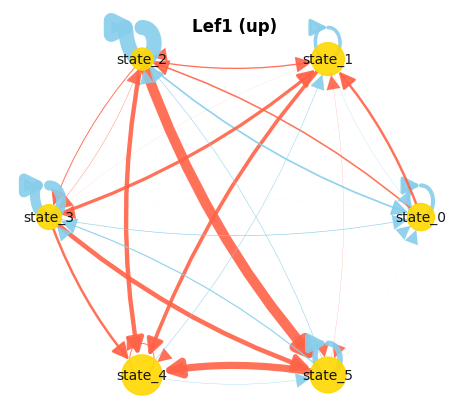

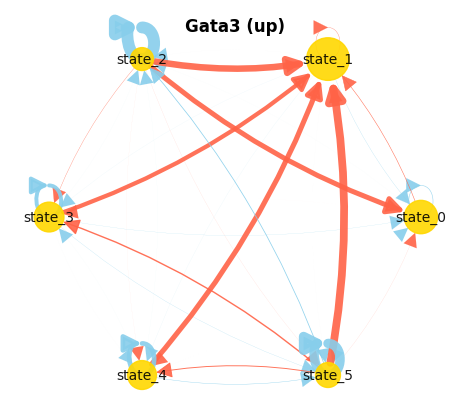

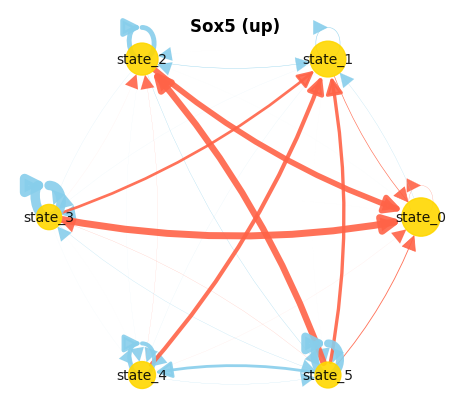

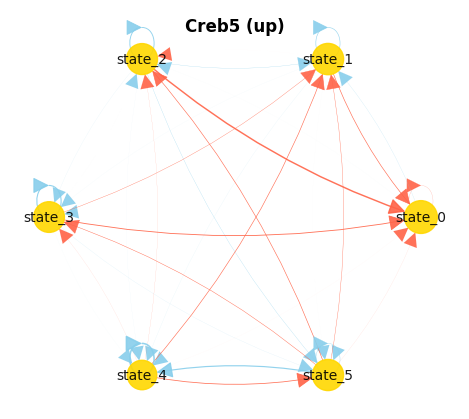

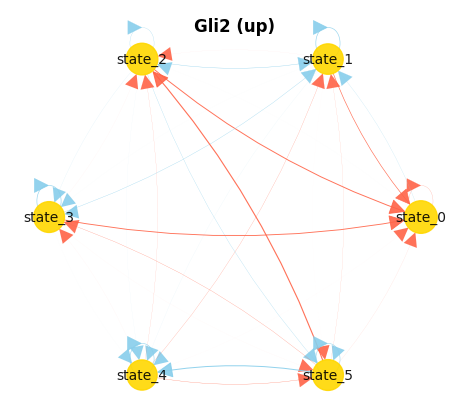

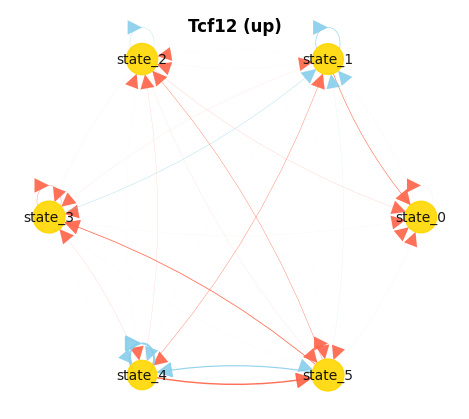

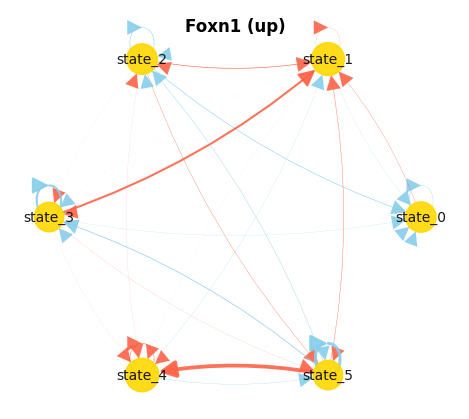

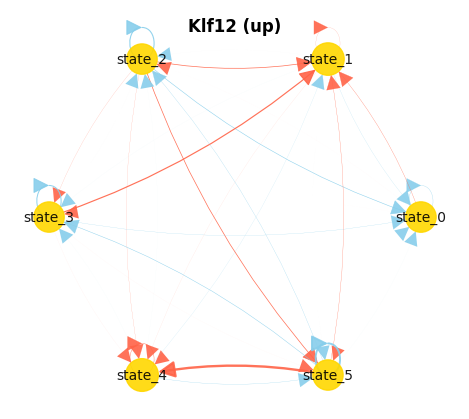

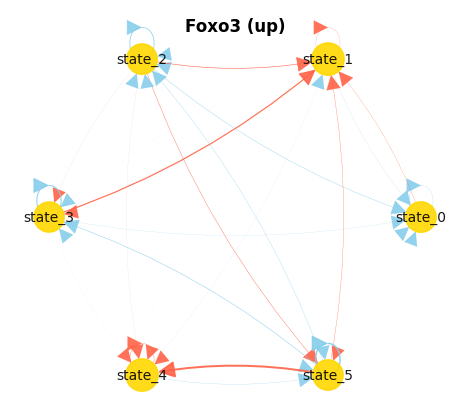

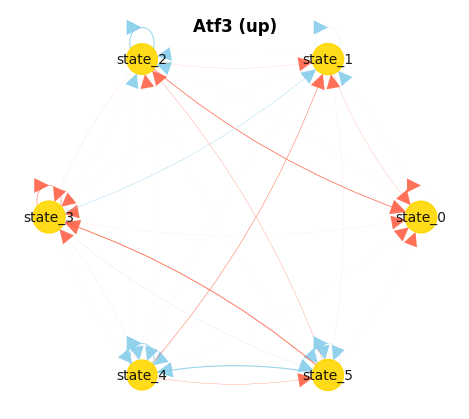

In [27]:
rep = 0
cells = results[rep, :, :, :]
inds = top_tfs_ind
rank = 1
for ind in inds:
    mat = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            mat[i, j] = np.mean(cells[y==i, ind, j])

    tf = tfs_kept[ind]

    import matplotlib.pyplot as plt
    import networkx as nx
    plt.figure(figsize=(4.5,4))
    G = nx.DiGraph()
    states = ['state_'+str(i) for i in range(6)]
    G.add_nodes_from(states)

    # 添加带权重的边，权重代表转移概率
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            G.add_edge(states[i], states[j], weight=mat[i,j])

    # 获取边的权重值和颜色
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    edge_colors = ['tomato' if weight >= 0 else 'skyblue' for weight in edge_weights]
    width = [abs(weight)*20 for weight in edge_weights]
    node_size=[np.sum(mat[i,:] + mat[:,i]) for i in range(6)]

    # 定义节点颜色
    node_colors = ['gold' for state in G.nodes]

    # 绘制图形
    pos = nx.circular_layout(G, scale=8)
    nx.draw(G, pos, with_labels=True, 
            node_color=node_colors, 
            node_size = [500*i+500 for i in node_size],
            width=width, 
            edge_color=edge_colors, connectionstyle="arc3,rad=0.1",
            font_size=10, font_color='black', alpha=0.9, arrowsize=25)

    plt.suptitle(tf+' (up)', fontweight='bold')
    plt.savefig('/nfs/public/xixi/scRegulate/figures/supp_fig8_up/'+str(rank)+'_'+tf+'.pdf')
    plt.show()
    plt.close()
    rank +=1

## State transitional graph 2 (on the umap embedding)

**Note:**

Before running the following code, extract the umap embeddings of the aggreated cells first.

We use Lef1 upregulation as an example to illustrate how to draw this type of graph

In [31]:
df_umap = pd.read_csv('./umap_embeddings_30cells.csv', index_col=0)
df_umap

,umap_1,umap_2
1,1.145485,-3.361284
2,1.035224,-3.152130
3,2.236676,-2.070518
4,1.723917,-2.150826
5,2.588820,-2.246674
...,...,...
839,6.138383,-1.935576
840,7.074377,-0.912593
841,5.671350,-1.650830
842,6.517179,-0.888968


[-1.45510954e-01  8.85074909e-02  5.61450532e-02  6.46499154e-04
  1.24105352e-04  8.78111881e-05]


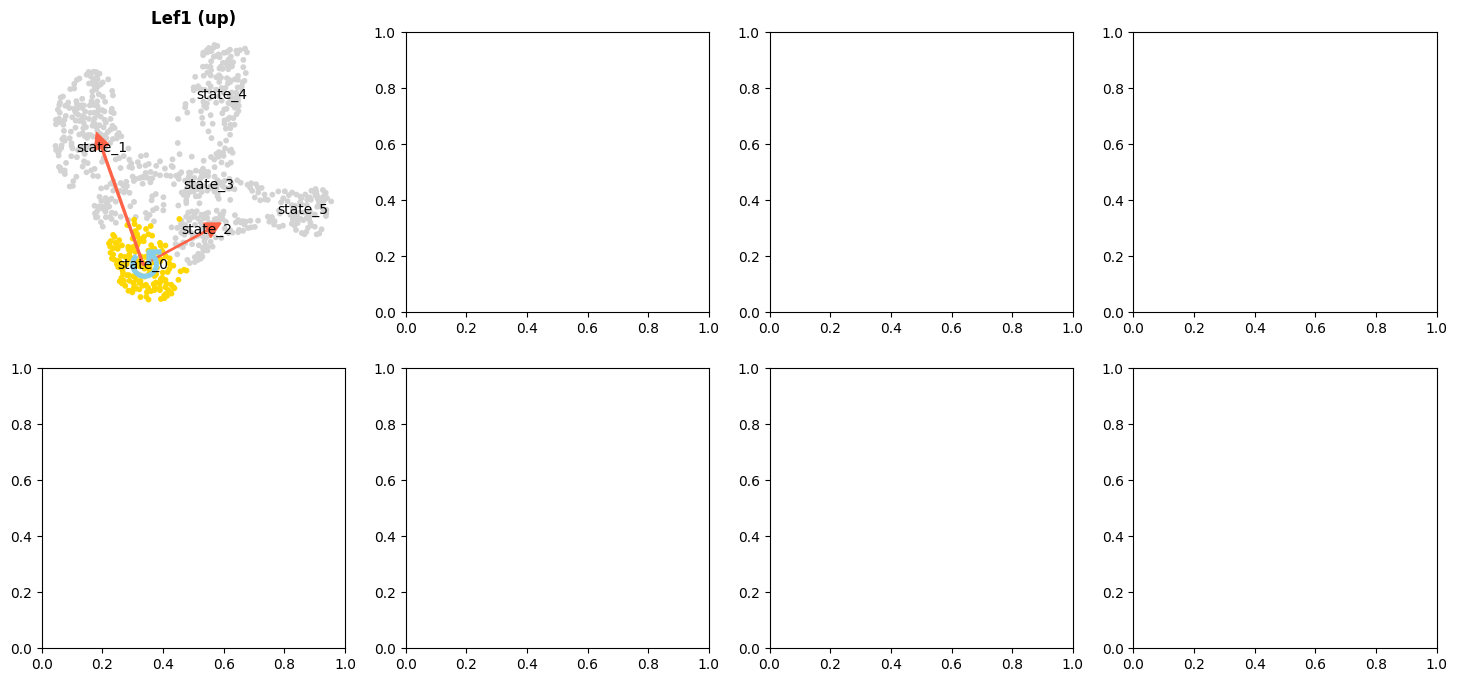

In [37]:
rep=0
start=0
cells = results[rep, y==start, :, :]

fig, axs = plt.subplots(2, 4, figsize=(18, 2*4))
count = 0
ind = tfs_kept.index('Lef1')
sub = cells[:, ind, :]
tf = tfs_kept[ind]
transitions = np.mean(sub, axis=0)
print(transitions)

colors = np.where(y == start, 'gold', 'lightgrey')
#colors[y == end] = 'thistle'

axs[int(count/4), int(count%4)].scatter(df_umap.iloc[:, 0], df_umap.iloc[:, 1], s=10, c=colors)
centroids = []
for label in np.unique(y):
    mask = (y == label)
    centroid_x = np.mean(np.array(df_umap.iloc[mask, 0]))
    centroid_y = np.mean(np.array(df_umap.iloc[mask, 1]))
    centroids.append((centroid_x, centroid_y))
    # 在图中标出类别名称
    axs[int(count/4), int(count%4)].text(centroid_x, centroid_y, f'state_{label}', fontsize=10, ha='center', va='center', color='black')

lists = [i for i in range(len(centroids)) if i != start]
for i in lists:
    weight = transitions[i]
    if np.abs(weight)>0.01:
        delta_x = centroids[i][0] - centroids[start][0]
        delta_y = centroids[i][1] - centroids[start][1]
        color = 'tomato' if weight >= 0 else 'skyblue'
        axs[int(count/4), int(count%4)].arrow(centroids[start][0], centroids[start][1], delta_x, delta_y, width=min(0.5, np.abs(weight)),
                  head_width=0.7, head_length=0.7, fc=color, ec=color)

weight = transitions[start]
if np.abs(weight)>0.01:
    color = 'tomato' if weight >= 0 else 'skyblue'
    axs[int(count/4), int(count%4)].plot(centroids[start][0],centroids[start][1], marker=r'$\circlearrowleft$', 
                                         ms=25, linewidth=0.1*np.abs(weight), c=color)
axs[int(count/4), int(count%4)].set_title(tf+' (up)', fontweight='bold')
axs[int(count/4), int(count%4)].axis('off')
count += 1
plt.savefig('/nfs/public/xixi/scRegulate/figures/fig5e2.pdf')
plt.show()

[-0.06184612  0.04743622 -0.5424766   0.03464777  0.15848213  0.3637566 ]


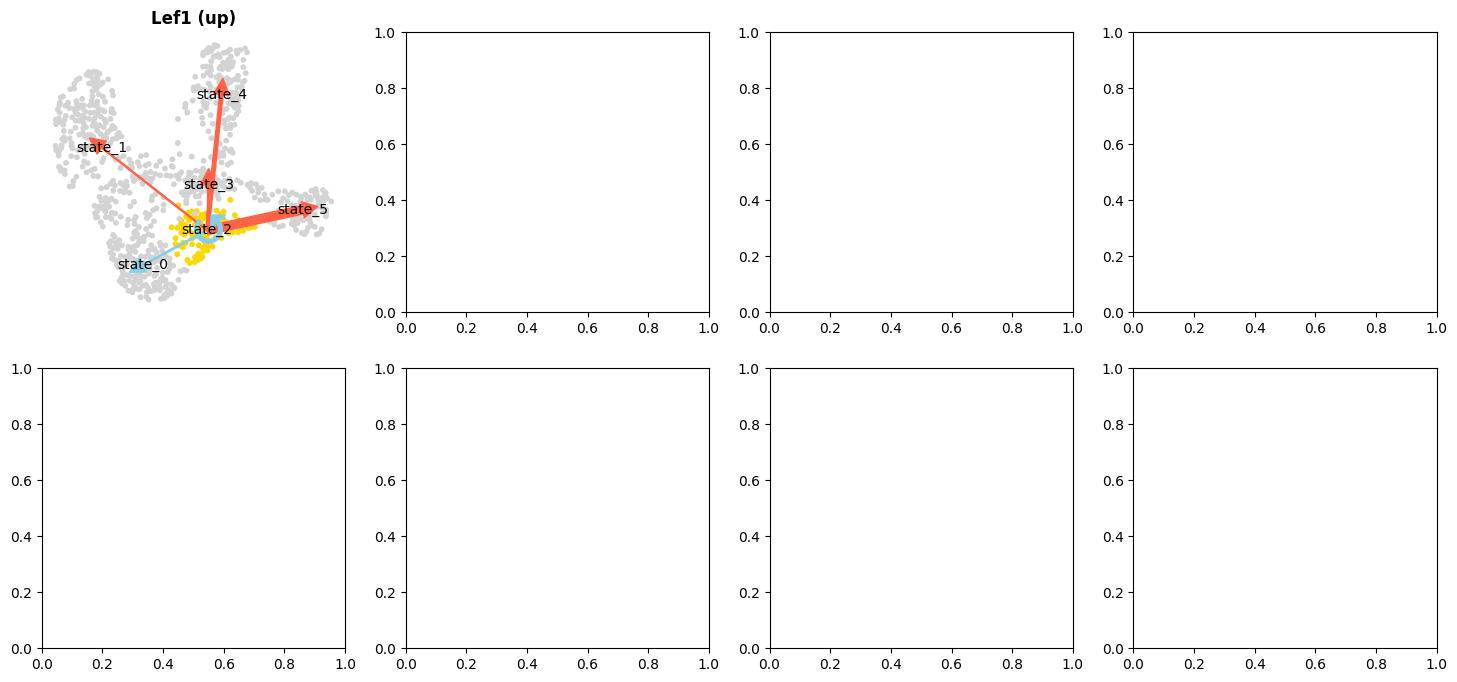

In [39]:
rep=0
start=2
cells = results[rep, y==start, :, :]

fig, axs = plt.subplots(2, 4, figsize=(18, 2*4))
count = 0
ind = tfs_kept.index('Lef1')
sub = cells[:, ind, :]
tf = tfs_kept[ind]
transitions = np.mean(sub, axis=0)
print(transitions)

colors = np.where(y == start, 'gold', 'lightgrey')
#colors[y == end] = 'thistle'

axs[int(count/4), int(count%4)].scatter(df_umap.iloc[:, 0], df_umap.iloc[:, 1], s=10, c=colors)
centroids = []
for label in np.unique(y):
    mask = (y == label)
    centroid_x = np.mean(np.array(df_umap.iloc[mask, 0]))
    centroid_y = np.mean(np.array(df_umap.iloc[mask, 1]))
    centroids.append((centroid_x, centroid_y))
    # 在图中标出类别名称
    axs[int(count/4), int(count%4)].text(centroid_x, centroid_y, f'state_{label}', fontsize=10, ha='center', va='center', color='black')

lists = [i for i in range(len(centroids)) if i != start]
for i in lists:
    weight = transitions[i]
    if np.abs(weight)>0.01:
        delta_x = centroids[i][0] - centroids[start][0]
        delta_y = centroids[i][1] - centroids[start][1]
        color = 'tomato' if weight >= 0 else 'skyblue'
        axs[int(count/4), int(count%4)].arrow(centroids[start][0], centroids[start][1], delta_x, delta_y, width=min(0.5, np.abs(weight)),
                  head_width=0.7, head_length=0.7, fc=color, ec=color)

weight = transitions[start]
if np.abs(weight)>0.01:
    color = 'tomato' if weight >= 0 else 'skyblue'
    axs[int(count/4), int(count%4)].plot(centroids[start][0],centroids[start][1], marker=r'$\circlearrowleft$', 
                                         ms=25, linewidth=0.1*np.abs(weight), c=color)
axs[int(count/4), int(count%4)].set_title(tf+' (up)', fontweight='bold')
axs[int(count/4), int(count%4)].axis('off')
count += 1
plt.savefig('/nfs/public/xixi/scRegulate/figures/fig5e3.pdf')
plt.show()
plt.close()

[-0.02368372  0.11679311  0.01327674 -0.36335281  0.08954922  0.16741746]


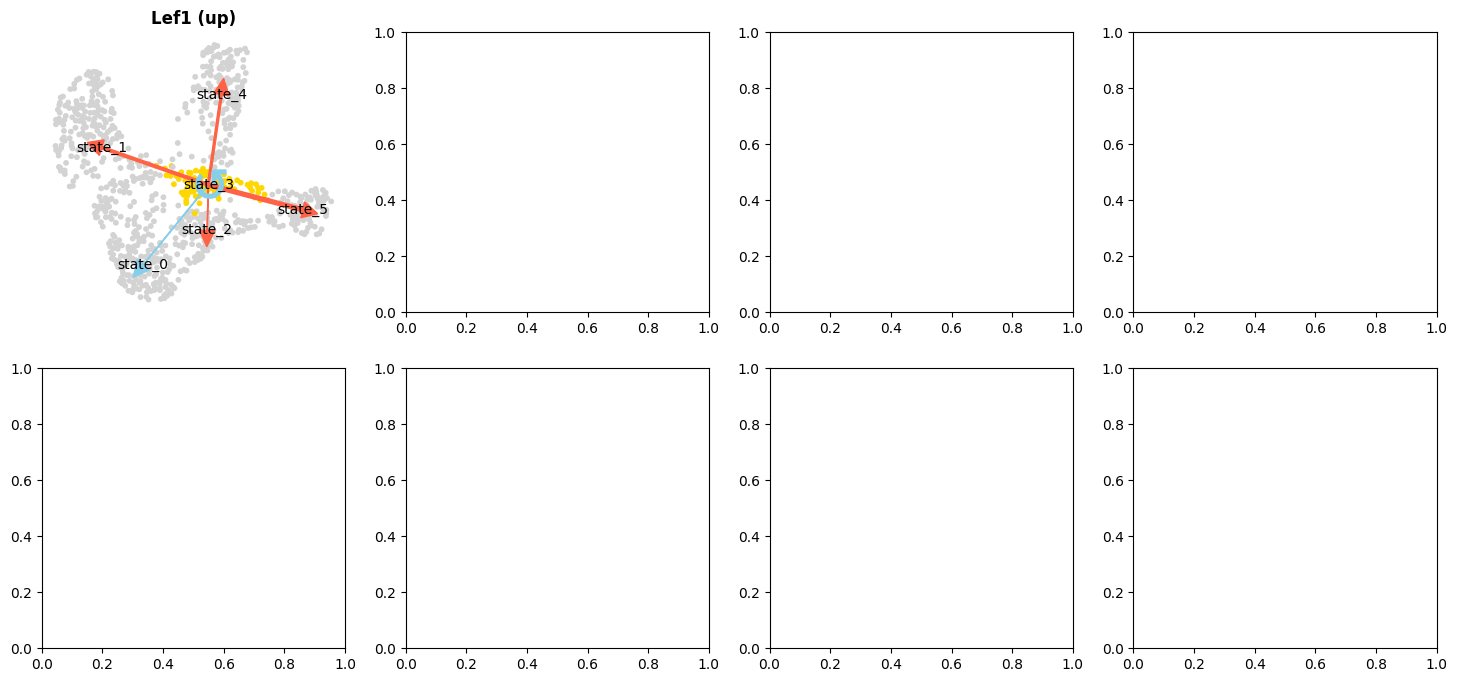

In [40]:
rep=0
start=3
cells = results[rep, y==start, :, :]

fig, axs = plt.subplots(2, 4, figsize=(18, 2*4))
count = 0
ind = tfs_kept.index('Lef1')
sub = cells[:, ind, :]
tf = tfs_kept[ind]
transitions = np.mean(sub, axis=0)
print(transitions)

colors = np.where(y == start, 'gold', 'lightgrey')
#colors[y == end] = 'thistle'

axs[int(count/4), int(count%4)].scatter(df_umap.iloc[:, 0], df_umap.iloc[:, 1], s=10, c=colors)
centroids = []
for label in np.unique(y):
    mask = (y == label)
    centroid_x = np.mean(np.array(df_umap.iloc[mask, 0]))
    centroid_y = np.mean(np.array(df_umap.iloc[mask, 1]))
    centroids.append((centroid_x, centroid_y))
    # 在图中标出类别名称
    axs[int(count/4), int(count%4)].text(centroid_x, centroid_y, f'state_{label}', fontsize=10, ha='center', va='center', color='black')

lists = [i for i in range(len(centroids)) if i != start]
for i in lists:
    weight = transitions[i]
    if np.abs(weight)>0.01:
        delta_x = centroids[i][0] - centroids[start][0]
        delta_y = centroids[i][1] - centroids[start][1]
        color = 'tomato' if weight >= 0 else 'skyblue'
        axs[int(count/4), int(count%4)].arrow(centroids[start][0], centroids[start][1], delta_x, delta_y, width=min(0.5, np.abs(weight)),
                  head_width=0.7, head_length=0.7, fc=color, ec=color)

weight = transitions[start]
if np.abs(weight)>0.01:
    color = 'tomato' if weight >= 0 else 'skyblue'
    axs[int(count/4), int(count%4)].plot(centroids[start][0],centroids[start][1], marker=r'$\circlearrowleft$', 
                                         ms=25, linewidth=0.1*np.abs(weight), c=color)
axs[int(count/4), int(count%4)].set_title(tf+' (up)', fontweight='bold')
axs[int(count/4), int(count%4)].axis('off')
count += 1
plt.savefig('/nfs/public/xixi/scRegulate/figures/fig5e4.pdf')
plt.show()
plt.close()

# Knockout

In [28]:
results = np.load('./predict_lineage_pseudotime/interpret_GAT/input_out_TF*0.npy')
results.shape

(10, 843, 165, 6)

In [29]:
#cls = {'Non-diabetic':0, 'Pre-T2D':1, 'T2D':2}
#from collections import Counter
import scipy.stats as ss
rank_all = []
for rep in range(10):
    #top = int(0.1*len(tfs_kept))
    cells = results[rep, :, :, :]
    rank = ss.rankdata(np.array([np.sum(abs(cells[:, i, :])) for i in range(len(tfs_kept))])) #rank from the smallest to the biggest
    rank_all.append(rank)

rank_all = np.array(rank_all)
top = 10
top_tfs_ind = np.argsort(np.mean(rank_all, axis=0))[::-1][:top]  # rank from the biggest to the smallest
print([tfs_kept[i] for i in top_tfs_ind])
top_over = [tfs_kept[i] for i in top_tfs_ind]

['Lef1', 'Gata3', 'Sox5', 'Gli2', 'Tcf12', 'Creb5', 'Atf3', 'Foxo3', 'Runx1', 'Jun']


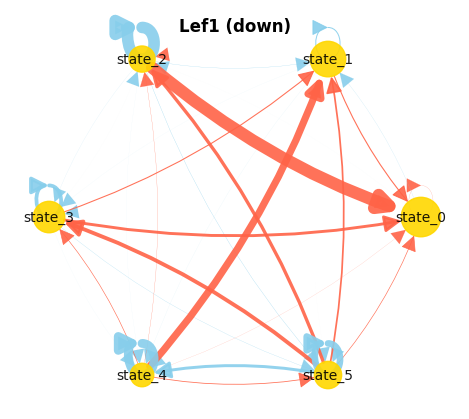

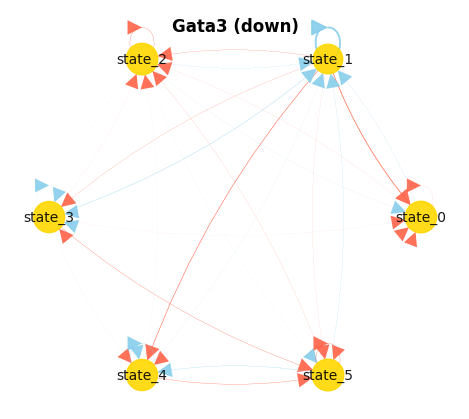

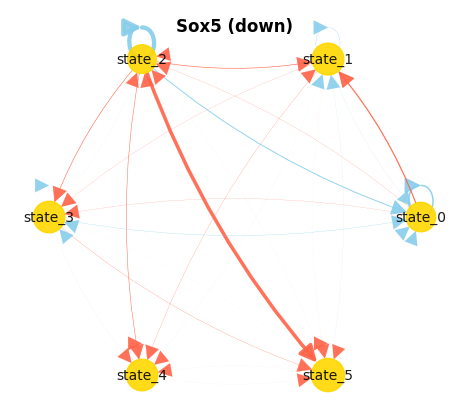

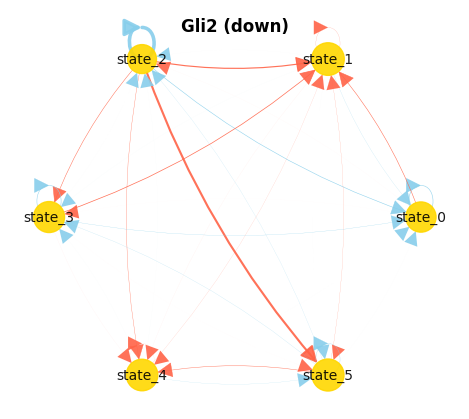

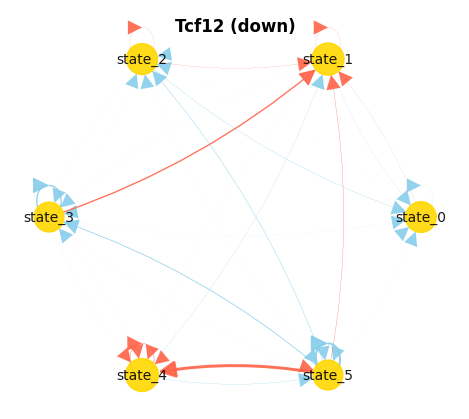

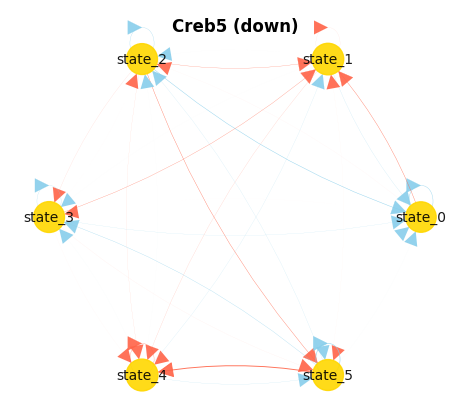

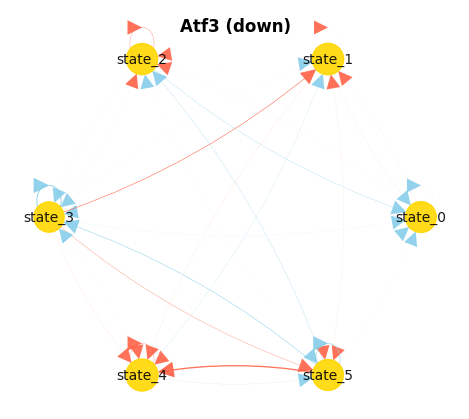

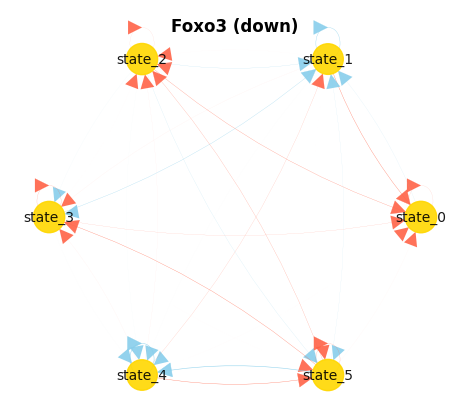

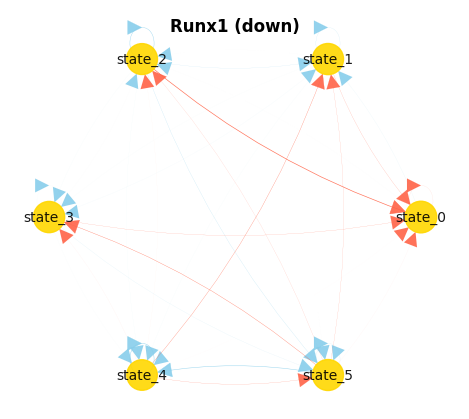

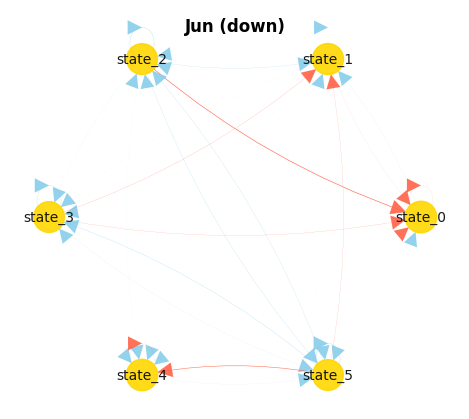

In [30]:
rep = 0
cells = results[rep, :, :, :]
inds = top_tfs_ind
rank = 1
for ind in inds:
    mat = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            mat[i, j] = np.mean(cells[y==i, ind, j])

    tf = tfs_kept[ind]

    import matplotlib.pyplot as plt
    import networkx as nx
    plt.figure(figsize=(4.5,4))
    G = nx.DiGraph()
    states = ['state_'+str(i) for i in range(6)]
    G.add_nodes_from(states)

    # 添加带权重的边，权重代表转移概率
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            G.add_edge(states[i], states[j], weight=mat[i,j])

    # 获取边的权重值和颜色
    edge_weights = [G[u][v]['weight'] for u, v in G.edges]
    edge_colors = ['tomato' if weight >= 0 else 'skyblue' for weight in edge_weights]
    width = [abs(weight)*20 for weight in edge_weights]
    node_size=[np.sum(mat[i,:] + mat[:,i]) for i in range(6)]

    # 定义节点颜色
    node_colors = ['gold' for state in G.nodes]

    # 绘制图形
    pos = nx.circular_layout(G, scale=8)
    nx.draw(G, pos, with_labels=True, 
            node_color=node_colors, 
            node_size = [500*i+500 for i in node_size],
            width=width, 
            edge_color=edge_colors, connectionstyle="arc3,rad=0.1",
            font_size=10, font_color='black', alpha=0.9, arrowsize=25)

    plt.suptitle(tf+' (down)', fontweight='bold')
    plt.savefig('/nfs/public/xixi/scRegulate/figures/supp_fig8_down/'+str(rank)+'_'+tf+'.pdf')
    plt.show()
    plt.close()
    rank +=1